In [2]:
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding, Flatten
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
import keras

/tmp/ipykernel_15353/2858468272.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-14 23:00:34.847528: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 23:00:34.847562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 23:00:34.875564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable 

In [3]:
train = pd.read_csv("train.csv",usecols=[0,3,4])
test = pd.read_csv("test.csv",usecols=[0,3])

In [4]:
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.info(),test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3263 non-null   int64 
 1   text    3263 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.1+ KB


(None, None)

In [6]:
train["text"].__contains__("@")

False

In [7]:
def prepro(t):
    t = t.lower()
    t = re.sub(r"[^a-zA-Z\s]","",t)
    t = re.sub(r"won\'t", " will not", t)
    t = re.sub(r"won\'t've", " will not have", t)
    t = re.sub(r"can\'t", " can not", t)
    t = re.sub(r"don\'t", " do not", t)
    t = re.sub(r"can\'t've", " can not have", t)
    t = re.sub(r"ma\'am", " madam", t)
    t = re.sub(r"let\'s", " let us", t)
    t = re.sub(r"ain\'t", " am not", t)
    t = re.sub(r"shan\'t", " shall not", t)
    t = re.sub(r"sha\n't", " shall not", t)
    t = re.sub(r"o\'clock", " of the clock", t)
    t = re.sub(r"y\'all", " you all", t)
    t = re.sub(r"n\'t", " not", t)
    t = re.sub(r"n\'t've", " not have", t)
    t = re.sub(r"\'re", " are", t)
    t = re.sub(r"\'s", " is", t)
    t = re.sub(r"\'d", " would", t)
    t = re.sub(r"\'d've", " would have", t)
    t = re.sub(r"\'ll", " will", t)
    t = re.sub(r"\'ll've", " will have", t)
    t = re.sub(r"\'t", " not", t)
    t = re.sub(r"\'ve", " have", t)
    t = re.sub(r"\'m", " am", t)
    t = re.sub(r"\'re", " are", t)
    t = re.sub(r"["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+"," ",t)
    t = " ".join(re.findall(r"[^\W\d_]+|\d+",t))
    t = re.sub("\s+"," ", t)

    return t 

In [8]:
train["text"] = train["text"].apply(prepro)

In [9]:
train.head()

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,people receive wildfires evacuation orders in ...,1
4,7,just got sent this photo from ruby alaska as s...,1


<Axes: >

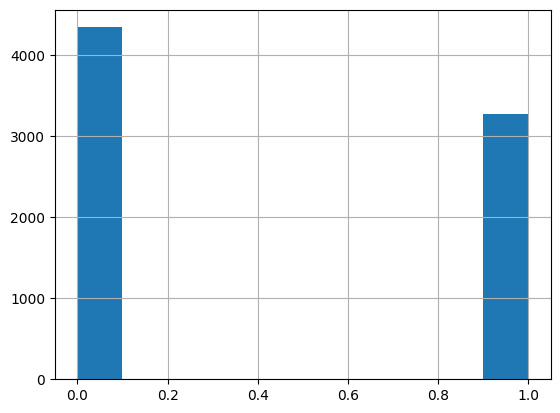

In [10]:
train["target"].hist()

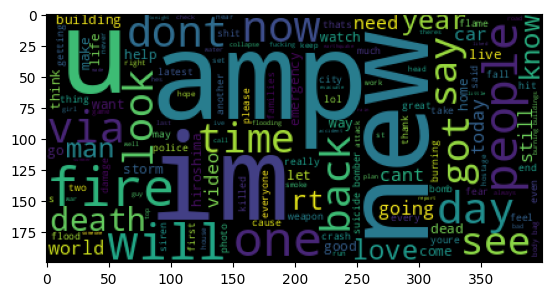

In [11]:
plt.imshow(WordCloud(background_color = 'black').generate(" ".join(train["text"])))

In [12]:
train["target"][:3000].sum(),train["target"][:3000].value_counts()

(1175,
 target
 0    1825
 1    1175
 Name: count, dtype: int64)

In [13]:
Xtra, Xtes, Ytra, Ytes = train_test_split(train["text"], train["target"],test_size=0.15)

In [14]:
countpipeline = Pipeline(
    [
        ("count",CountVectorizer()),
        ("model",LogisticRegression(random_state=44,C=0.3,max_iter=500,solver="sag"))
    ]
)

In [15]:
countpipeline.fit(Xtra,Ytra)

Pipeline(steps=[('count', CountVectorizer()),
                ('model',
                 LogisticRegression(C=0.3, max_iter=500, random_state=44,
                                    solver='sag'))])

In [16]:
countpipeline.score(Xtra,Ytra),countpipeline.score(Xtes,Ytes)

(0.9259774377994128, 0.8038528896672504)

<Axes: >

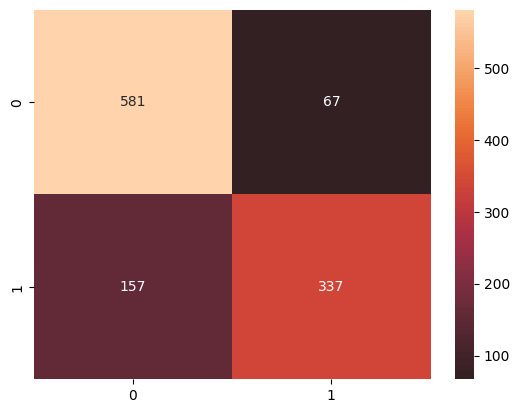

In [17]:
sns.heatmap(confusion_matrix(Ytes,countpipeline.predict(Xtes)),center=True,annot=True,fmt="g")

In [18]:
tfidpipeline = Pipeline(
    [
        ("tfid",TfidfVectorizer()),
        ("model",LogisticRegression(random_state=44,C=0.3,max_iter=500,solver="sag"))
    ]
)

In [19]:
tfidpipeline.fit(Xtra,Ytra)

Pipeline(steps=[('tfid', TfidfVectorizer()),
                ('model',
                 LogisticRegression(C=0.3, max_iter=500, random_state=44,
                                    solver='sag'))])

In [20]:
tfidpipeline.score(Xtra,Ytra),tfidpipeline.score(Xtes,Ytes)

(0.8369649204141555, 0.8021015761821366)

<Axes: >

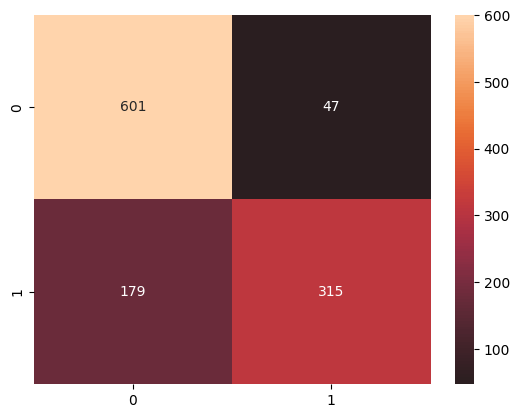

In [21]:
sns.heatmap(confusion_matrix(Ytes,tfidpipeline.predict(Xtes)),center=True,annot=True,fmt="g")

In [22]:
glove_embeding = {}
with open("/home/ruthvik/stuff/python/ml/nlp n chatbots exp/glove.6B.100d.txt") as glove_file:
    for line in glove_file:
        parts = line.strip().split()
        embedding = np.array([float(x) for x in parts[1:]])
        glove_embeding[parts[0]] = embedding

In [23]:
glove_embeding["banana"]

array([-0.34028  ,  0.46436  , -0.083324 ,  0.20186  , -0.17831  ,
       -0.4663   ,  0.61793  ,  0.30129  ,  0.5728   , -0.34783  ,
       -0.9216   ,  0.30484  ,  0.30382  ,  0.58035  ,  0.12112  ,
        0.77288  ,  1.1547   , -0.576    ,  0.51471  ,  0.21552  ,
        0.21106  ,  0.67875  ,  1.1962   ,  0.11142  ,  0.50809  ,
        1.1873   ,  0.035288 , -0.88952  ,  0.042803 , -0.36714  ,
        0.37993  ,  0.61945  ,  1.0194   , -0.95084  , -0.0072258,
        0.69454  ,  0.38692  , -0.18544  ,  0.2885   , -0.81279  ,
       -0.46473  , -0.82623  ,  0.42778  , -0.14064  ,  0.30173  ,
        0.074418 , -0.40044  ,  0.33969  , -0.62917  , -0.054449 ,
       -0.78469  ,  0.2354   , -0.78359  ,  0.74708  , -0.31074  ,
       -0.07038  , -0.34623  ,  0.33849  ,  0.89621  ,  0.30288  ,
        0.012978 ,  0.020869 , -0.14436  , -0.40914  ,  0.16651  ,
       -0.88124  , -0.078419 ,  0.048156 ,  0.27032  , -0.81761  ,
        0.027778 ,  0.62487  ,  0.1549   , -0.15838  ,  0.0886

In [24]:
Xtra

7183                      junsuisengen changing my weapon
4475    hot c specially modified to land in a stadium ...
4930    raynbowaffair editor in chief diamondkesawn re...
6436    security personnel killed in iraq suicide bomb...
3769    in the words of charlie daniels fire on the mo...
                              ...                        
5667    last chance animal rescue has new posts httptc...
2468    trains derailment its the freakiest of freak a...
5181    we are now prepared to obliterate more rapidly...
1469    gemmahentsch megynkelly dloesch i can not envi...
5177    watch sarah palin obliterate planned parenthoo...
Name: text, Length: 6471, dtype: object

In [25]:
t = Tokenizer()
t.fit_on_texts(train["text"])

In [26]:
word_count = len(t.word_index)+1

In [27]:
word_count

21492

In [28]:
encdText = t.texts_to_sequences(Xtra)

In [29]:
encdTextT = t.texts_to_sequences(Xtes)

In [30]:
padded = pad_sequences(encdText,maxlen=31,padding="post")

In [31]:
paddedT = pad_sequences(encdTextT,maxlen=31,padding="post")

In [32]:
embedding_matrix = np.zeros((word_count, 100))

In [33]:
for word,i in t.word_index.items():
    embedding_vector = glove_embeding.get(word)
    if embedding_vector is not None:embedding_matrix[i] = embedding_vector

In [130]:
modelGlove = Sequential()

In [131]:
modelGlove.add(Embedding(21492, 100, weights=[embedding_matrix], input_length=31, trainable=False))
modelGlove.add(Flatten())
modelGlove.add(Dense(512, activation="tanh"))
modelGlove.add(keras.layers.Dropout(0.2))
modelGlove.add(Dense(256, activation="tanh"))
modelGlove.add(keras.layers.Dropout(0.2))
modelGlove.add(Dense(128, activation="tanh"))
modelGlove.add(keras.layers.Dropout(0.2))
modelGlove.add(Dense(64, activation="tanh"))
modelGlove.add(Dense(32, activation="tanh"))
modelGlove.add(Dense(16, activation="tanh"))
modelGlove.add(Dense(4, activation="tanh"))
modelGlove.add(Dense(1))

In [132]:
modelGlove.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 31, 100)           2149200   
                                                                 
 flatten_8 (Flatten)         (None, 3100)              0         
                                                                 
 dense_37 (Dense)            (None, 512)               1587712   
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_38 (Dense)            (None, 256)               131328    
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_39 (Dense)            (None, 128)              

In [133]:
modelGlove.compile(optimizer="adam",loss="binary_crossentropy",metrics=[keras.metrics.BinaryAccuracy()])

In [134]:
history = modelGlove.fit(padded,Ytra,epochs=30,verbose=1,batch_size=32)

Epoch 1/30
203/203 [==============================] - 3s 4ms/step - loss: 6.6688 - binary_accuracy: 0.5654
Epoch 2/30
203/203 [==============================] - 1s 4ms/step - loss: 0.7998 - binary_accuracy: 0.7203
Epoch 3/30
203/203 [==============================] - 1s 4ms/step - loss: 0.4887 - binary_accuracy: 0.7860
Epoch 4/30
203/203 [==============================] - 1s 4ms/step - loss: 0.4599 - binary_accuracy: 0.8265
Epoch 5/30
203/203 [==============================] - 1s 4ms/step - loss: 0.4096 - binary_accuracy: 0.8436
Epoch 6/30
203/203 [==============================] - 1s 4ms/step - loss: 0.3717 - binary_accuracy: 0.8618
Epoch 7/30
203/203 [==============================] - 1s 5ms/step - loss: 0.3549 - binary_accuracy: 0.8710
Epoch 8/30
203/203 [==============================] - 1s 4ms/step - loss: 0.3233 - binary_accuracy: 0.8819
Epoch 9/30
203/203 [==============================] - 1s 5ms/step - loss: 0.2863 - binary_accuracy: 0.8994
Epoch 10/30
203/203 [================

In [123]:
modelGlove.evaluate(paddedT,Ytes)

36/36 [==============================] - 0s 2ms/step - loss: 0.5623 - binary_accuracy: 0.7785


[0.5622563362121582, 0.778458833694458]

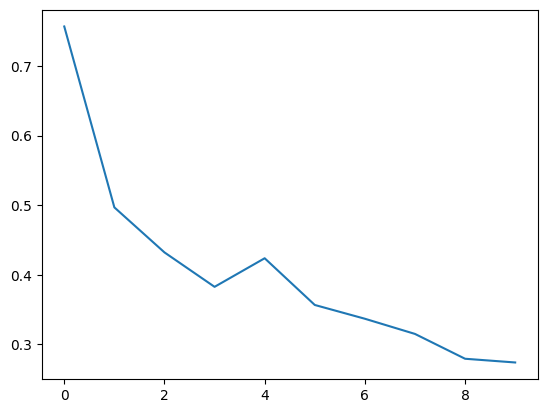

In [124]:
plt.plot(history.history["loss"])

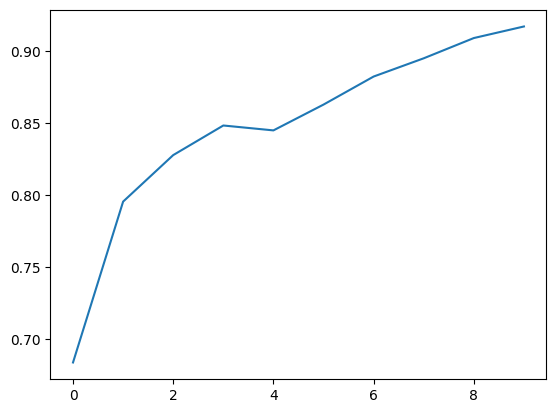

In [125]:
plt.plot(history.history["binary_accuracy"])


In [92]:
modelGlove.save("model0")

INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets
